# Lab 15 — Regularization for MLPs
In this lab, you will investigate how different regularization techniques affect the
training dynamics and generalization performance of a simple neural network.

We will implement and compare:
- **Dropout** — randomly dropping neurons during training
- **L1 and L2 regularization** — penalizing large weights  
- **Early stopping** — stopping training when validation performance degrades

In [13]:
import torch
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

set_matplotlib_formats('png', 'pdf')

## Data Generation

We will use a noisy 2D classification dataset to illustrate overfitting and the effects of regularization. The training data has high noise to encourage overfitting, while the validation data is cleaner to test generalization.

Training set: torch.Size([350, 2]), Validation set: torch.Size([150, 2])


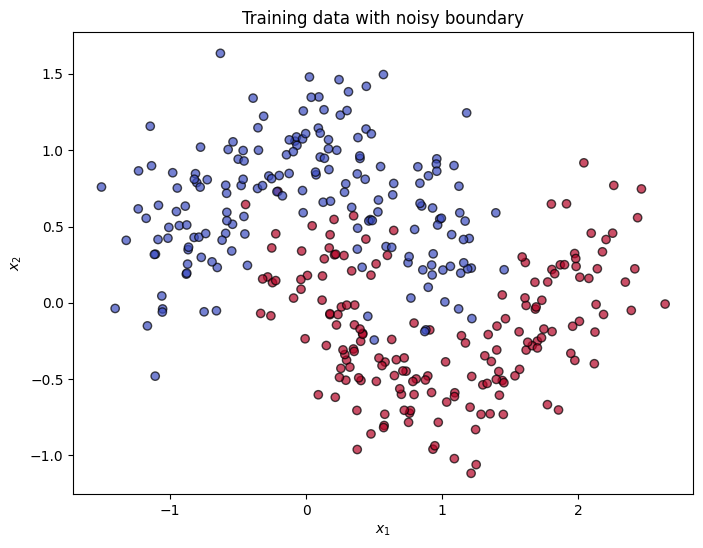

In [14]:
np.random.seed(42)
torch.manual_seed(42)

X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to torch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

print(f"Training set: {x_train.shape}, Validation set: {x_val.shape}")

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", alpha=0.7, edgecolor='k')
plt.title("Training data with noisy boundary")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Network Architecture and Forward Pass

We'll implement a neural network with:
- **Input layer**: 2 neurons ($x_1$, $x_2$)
- **Hidden layer 1**: 20 neurons with tanh activation
- **Hidden layer 2**: 10 neurons with tanh activation
- **Output layer**: 1 neuron with sigmoid activation (for binary classification)

In [15]:
def sigmoid(x: Tensor) -> Tensor:
    return 1 / (1 + torch.exp(-x))

def tanh(x: Tensor) -> Tensor:
    return torch.tanh(x)

In [16]:
# Define network architecture: [input_size, hidden1, hidden2, ..., output_size]
ARCHITECTURE = [2, 20, 10, 1]

def count_parameters(layer_sizes):
    """Count total parameters for a given architecture."""
    total = 0
    for i in range(len(layer_sizes) - 1):
        total += layer_sizes[i] * layer_sizes[i+1] + layer_sizes[i+1]
    return total

def initialize_parameters(layer_sizes, scale=0.3):
    """Initialize parameters for the network."""
    n_params = count_parameters(layer_sizes)
    return torch.randn(n_params) * scale


### Ex. 1: Forward Pass with Dropout (3P)

Implement a forward pass with dropout support. Dropout randomly drops neurons during training to prevent overfitting.


In [17]:
def predict_with_dropout(
    x: Tensor,
    params: Tensor,
    layer_sizes: list[int],
    dropout_rate: float = 0.0,
    training: bool = True
) -> tuple[Tensor, dict]:
    """
    Forward pass through network with dropout support.

    Args:
        x: Input data (N x input_dim)
        params: All network parameters as a flat tensor
        layer_sizes: Architecture [input_size, hidden1, ..., output_size]
        dropout_rate: Probability of dropping a neuron
        training: Whether in training mode

    Returns:
        output: Network predictions
        cache: Dictionary storing intermediate values for backprop
    """
    cache = {'layer_sizes': layer_sizes}
    activations = [x]
    dropout_masks = []

    # Unpack parameters dynamically
    idx = 0
    weights = []
    biases = []

    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i+1]

        # Extract bias and weight for this layer
        b = params[idx:idx + n_out]
        idx += n_out

        W = params[idx:idx + n_in * n_out].view(n_in, n_out)
        idx += n_in * n_out

        weights.append(W)
        biases.append(b)

    # Forward pass through layers
    for i in range(len(weights)):
        W, b = weights[i], biases[i]

        # Linear transformation
        z_in = activations[-1] @ W + b
        cache[f'z{i}_in'] = z_in

        # Activation function (before dropout)
        if i < len(weights) - 1:  # Hidden layers use tanh
            z_out_pre_dropout = tanh(z_in)
        else:  # Output layer uses sigmoid
            z_out_pre_dropout = sigmoid(z_in)

        # Store pre-dropout activation
        cache[f'z{i}_out_pre_dropout'] = z_out_pre_dropout

        # TODO: Apply dropout to hidden layers only
        # Hint: Use inverted dropout with scaling factor 1/(1-dropout_rate)
        # Hint: Only apply dropout during training (check the 'training' flag)

        # Apply dropout (hidden layers only, during training)
        if training and dropout_rate > 0.0 and i < len(weights) - 1:
            mask = (torch.rand_like(z_out_pre_dropout) > dropout_rate).float()
            z_out = z_out_pre_dropout * mask / (1.0 - dropout_rate)
            cache[f'dropout_mask{i}'] = mask
        else:
            z_out = z_out_pre_dropout
            cache[f'dropout_mask{i}'] = None


        cache[f'z{i}_out'] = z_out
        cache[f'W{i}'] = W
        cache[f'b{i}'] = b
        activations.append(z_out)

    cache['activations'] = activations

    return activations[-1], cache

# Test
params = initialize_parameters(ARCHITECTURE)
predictions, cache = predict_with_dropout(x_train, params, ARCHITECTURE, dropout_rate=0.0, training=False)

## Exercise 2 — Loss Function with Regularization (2P)

Extend the binary cross-entropy loss to include L1 and L2 regularization.

**Regularization formulas**:
- **L1**: $\lambda_1 \sum |w_i|$ (encourages sparsity)
- **L2**: $\lambda_2 \sum w_i^2$ (encourages small weights)

Note: We only regularize weights, not biases.

In [18]:
def get_loss_with_regularization(
    target: Tensor,
    pred: Tensor,
    params: Tensor,
    layer_sizes: list[int],
    lambda_l1: float = 0.0,
    lambda_l2: float = 0.0
) -> Tensor:
    """
    Compute binary cross-entropy loss with L1/L2 regularization.

    Args:
        target: True labels
        pred: Predicted probabilities
        params: Network parameters as flat tensor
        layer_sizes: Architecture [input_size, hidden1, ..., output_size]
        lambda_l1: L1 regularization strength
        lambda_l2: L2 regularization strength
    """
    # Ensure target and pred have matching shapes
    if target.dim() == 1 and pred.dim() == 2:
        target = target.unsqueeze(1)
    elif target.dim() == 2 and pred.dim() == 1:
        pred = pred.unsqueeze(1)

    # Data loss (binary cross-entropy)
    data_loss = -torch.mean(
        target * torch.log(pred + 1e-15) +
        (1 - target) * torch.log(1 - pred + 1e-15)
    )

    # TODO: Add L1 and L2 regularization to weights
    idx = 0
    l1_reg = 0.0
    l2_reg = 0.0

    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i + 1]

        # Skip biases first
        idx += n_out

        # Extract weights for this layer
        W = params[idx: idx + n_in * n_out]
        idx += n_in * n_out

        # Accumulate regularization terms
        if lambda_l1 > 0:
            l1_reg += torch.sum(torch.abs(W))
        if lambda_l2 > 0:
            l2_reg += torch.sum(W ** 2)

    total_loss = data_loss + lambda_l1 * l1_reg + lambda_l2 * l2_reg

    return total_loss


## Exercise 3 — Backpropagation with Dropout and Regularization (3P)

Implement gradient computation with support for dropout and L1/L2 regularization.


In [19]:
def get_gradients_with_regularization(
    target: Tensor,
    cache: dict,
    params: Tensor,
    lambda_l1: float = 0.0,
    lambda_l2: float = 0.0,
    dropout_rate: float = 0.0
) -> Tensor:
    """
    Compute gradients via backpropagation with dropout and regularization.
    Works for any architecture defined in cache['layer_sizes'].
    """
    layer_sizes = cache['layer_sizes']
    activations = cache['activations']
    n_layers = len(layer_sizes) - 1
    N = activations[0].shape[0]

    # Initialize gradient list
    gradients = []

    # Backprop through loss and output layer
    fout = activations[-1]

    # Ensure target has same shape as fout to prevent broadcasting issues
    if target.dim() == 1:
        target = target.unsqueeze(1)

    dL_dfout = -target / (fout + 1e-15) + (1 - target) / (1 - fout + 1e-15)

    # Output layer uses sigmoid - derivative is fout * (1 - fout)
    dfout_dfin = fout * (1 - fout)

    dL_dz = dL_dfout * dfout_dfin

    # Backpropagate through all layers (from output to input)
    for i in range(n_layers - 1, -1, -1):
        W = cache[f'W{i}']
        z_prev = activations[i]

        # Gradient w.r.t. bias and weights
        dL_db = torch.mean(dL_dz, dim=0)
        dL_dW = (z_prev.T @ dL_dz) / N

        # TODO: Add regularization gradients to weights
        if lambda_l1 > 0:
            dL_dW += lambda_l1 * torch.sign(W) / N
        if lambda_l2 > 0:
            dL_dW += 2.0 * lambda_l2 * W / N

        # Store gradients (in reverse order, we'll reverse later)
        gradients.append((dL_db, dL_dW))

        # Backprop to previous layer (if not input layer)
        if i > 0:
            dL_dz_prev = dL_dz @ W.T

            # TODO: Apply dropout mask to gradients
            # Hint: Don't forget to scale by 1/(1-dropout_rate) for inverted dropout
            mask = cache.get(f'dropout_mask{i-1}', None)
            if mask is not None and dropout_rate > 0.0:
                dL_dz_prev = dL_dz_prev * mask / (1.0 - dropout_rate)


            # Apply activation derivative (tanh for hidden layers)
            z_prev_in = cache[f'z{i-1}_in']
            dz_prev_out = 1.0 - torch.tanh(z_prev_in)**2

            # Element-wise multiplication
            dL_dz = dL_dz_prev * dz_prev_out

    # Reverse gradients to match parameter order and flatten
    gradients = gradients[::-1]
    grad_flat = []
    for dL_db, dL_dW in gradients:
        grad_flat.append(dL_db)
        grad_flat.append(dL_dW.flatten())

    return torch.cat(grad_flat)


## Exercise 4 — Training with Early Stopping (2P)

Implement a training loop that monitors validation performance and stops when validation loss stops improving with a patience counter.


In [20]:
def train_network(
    x_train: Tensor,
    y_train: Tensor,
    x_val: Tensor,
    y_val: Tensor,
    layer_sizes: list[int],
    learning_rate: float = 0.5,
    max_steps: int = 1000,
    dropout_rate: float = 0.0,
    lambda_l1: float = 0.0,
    lambda_l2: float = 0.0,
    patience: int = 50,
    verbose: bool = False
) -> tuple[Tensor, dict]:
    """
    Train the network with early stopping.

    Args:
        layer_sizes: Network architecture [input_size, hidden1, ..., output_size]

    Returns:
        best_params: Parameters achieving best validation loss
        history: Dictionary with training and validation losses
    """
    # Initialize parameters
    params = initialize_parameters(layer_sizes)

    # TODO: Implement early stopping logic
    # Hint: Track best_val_loss, best_params, and epochs_without_improvement
    # Hint: Create history dict with 'train_loss' and 'val_loss' lists

    best_params = params.clone()
    best_val_loss = float("inf")
    epochs_without_improvement = 0
    history = {"train_loss": [], "val_loss": []}

    for step in range(max_steps):
        #forward + loss (train)
        pred_train, cache_train = predict_with_dropout(
            x_train,
            params,
            layer_sizes,
            dropout_rate=dropout_rate,
            training=True,
        )

        train_loss = get_loss_with_regularization(
            y_train,
            pred_train,
            params,
            layer_sizes,
            lambda_l1=lambda_l1,
            lambda_l2=lambda_l2,
        )

        #backprop (train)
        grads = get_gradients_with_regularization(
            y_train,
            cache_train,
            params,
            lambda_l1=lambda_l1,
            lambda_l2=lambda_l2,
            dropout_rate=dropout_rate,
        )

        #gd step
        params = params - learning_rate * grads

        #validation loss (no dropout)
        with torch.no_grad():
            pred_val, _ = predict_with_dropout(
                x_val,
                params,
                layer_sizes,
                dropout_rate=0.0,
                training=False,
            )
            val_loss = get_loss_with_regularization(
                y_val,
                pred_val,
                params,
                layer_sizes,
                lambda_l1=lambda_l1,
                lambda_l2=lambda_l2,
            )

        #Log losses
        history["train_loss"].append(train_loss.item())
        history["val_loss"].append(val_loss.item())

        #early stopping logic
        if val_loss < best_val_loss - 1e-8:
            best_val_loss = val_loss
            best_params = params.clone()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if verbose and (step == 0 or (step + 1) % 10 == 0):
            print(
                f"Step {step+1}/{max_steps} | "
                f"train_loss={train_loss.item():.4f} | "
                f"val_loss={val_loss.item():.4f} | "
                f"no_improve={epochs_without_improvement}"
            )

        if epochs_without_improvement >= patience:
            if verbose:
                print(
                    f"Early stopping at step {step+1} "
                    f"(best val_loss={best_val_loss.item():.4f})"
                )
            break

    return best_params, history


## Compare Regularization Techniques

Train models with different regularization strategies and compare their performance.

In [21]:
# Train models with different regularization strategies
params_baseline, history_baseline = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, patience=500
)

params_dropout, history_dropout = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, dropout_rate=0.15, patience=200
)

params_l1, history_l1 = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, lambda_l1=0.002, patience=200
)

params_l2, history_l2 = train_network(
    x_train, y_train_t, x_val, y_val_t,
    layer_sizes=ARCHITECTURE,
    learning_rate=0.5, max_steps=2000, lambda_l2=0.005, patience=200
)


## Visualization

Plot training curves to compare the different regularization techniques.

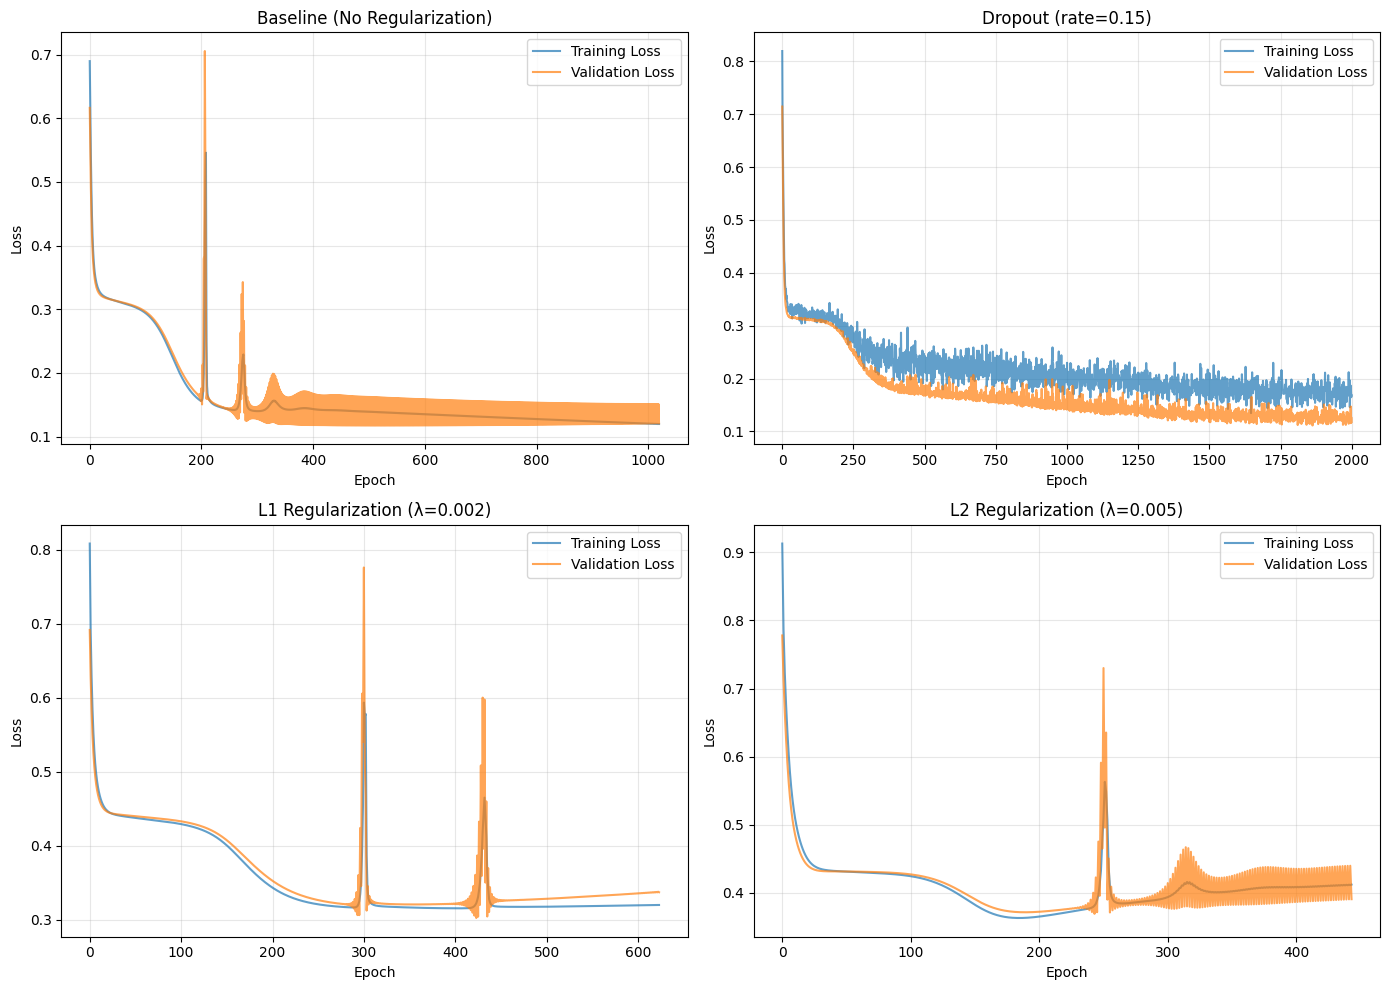

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = [
    ("Baseline (No Regularization)", history_baseline),
    ("Dropout (rate=0.15)", history_dropout),
    ("L1 Regularization (λ=0.002)", history_l1),
    ("L2 Regularization (λ=0.005)", history_l2)
]

for idx, (name, history) in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    ax.plot(history['train_loss'], label='Training Loss', alpha=0.7)
    ax.plot(history['val_loss'], label='Validation Loss', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

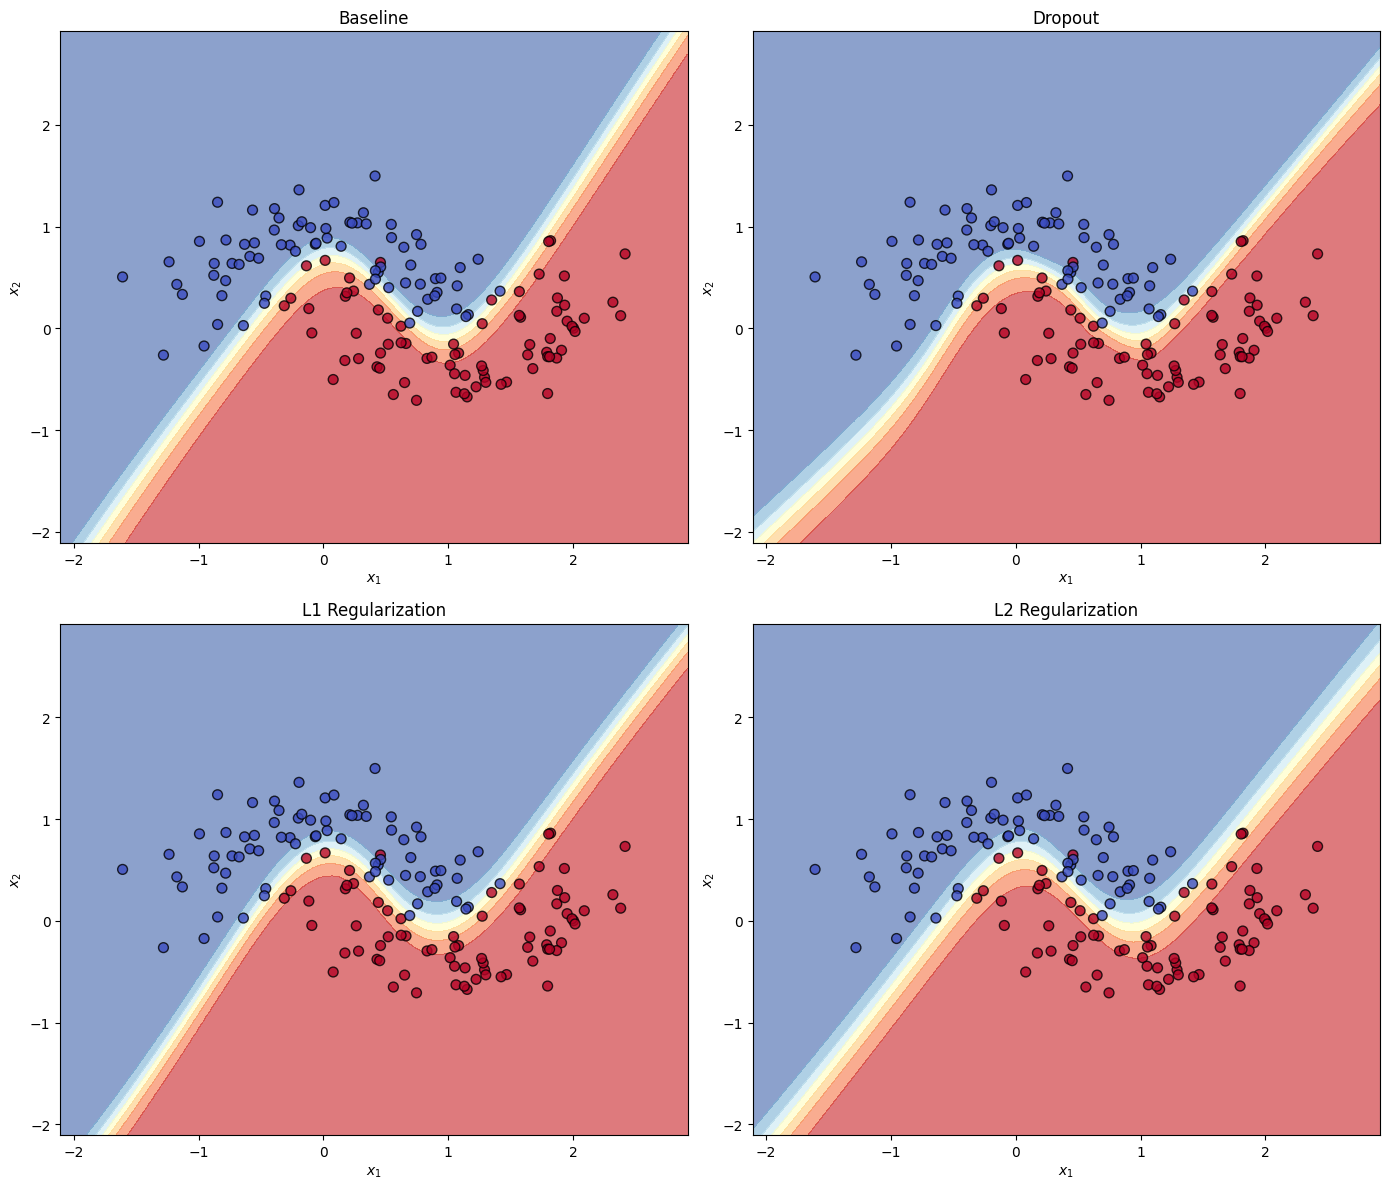

In [23]:
def plot_decision_boundary(ax, x_data, y_data, params, layer_sizes, title):
    """Plot decision boundary for a trained network."""
    # Create grid
    grid_range = torch.linspace(x_data.min()-0.5, x_data.max()+0.5, 100)
    grid_x, grid_y = torch.meshgrid(grid_range, grid_range, indexing='xy')
    grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T

    # Get predictions
    pred, _ = predict_with_dropout(
        grid_data, params, layer_sizes,
        dropout_rate=0.0, training=False
    )
    pred = pred.view(grid_x.shape).detach().numpy()

    # Plot
    ax.contourf(grid_x.numpy(), grid_y.numpy(), pred, cmap='RdYlBu_r', alpha=0.6)
    ax.scatter(x_data[:, 0], x_data[:, 1], c=y_data, cmap='coolwarm',
               edgecolor='k', s=50, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

# Plot all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

model_params = [
    ("Baseline", params_baseline),
    ("Dropout", params_dropout),
    ("L1 Regularization", params_l1),
    ("L2 Regularization", params_l2)
]

for idx, (name, params) in enumerate(model_params):
    ax = axes[idx // 2, idx % 2]
    plot_decision_boundary(ax, x_val, y_val_t.numpy(), params, ARCHITECTURE, name)

plt.tight_layout()
plt.show()